Problem 16 from the advent of code calendar 2022.

December 21, 2022

Updated to version 2 on December 26 when switched to using a Class because of debugging

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import graphviz

np.set_printoptions(linewidth=250)

#with open("16_example.txt") as f:
#    contents = f.readlines()

with open("16.txt") as f:
    contents = f.readlines()

In [2]:
#Parse the contents
flow_rates = {}
tunnels = {}

for l in contents:
    a,b = l.rstrip().split(';')
    #Get valve name
    vn = a.split(' ')[1]
    #Get flow rate
    flow_rates[vn] = int(a.split('=')[1])
    #Get tunnel list
    tunnels[vn] = [x.lstrip().rstrip() for x in b.lstrip(' tunnels lead to valves ').split(',')]
    

    

In [3]:
tunnels

{'BT': ['EZ', 'TO'],
 'OJ': ['UV', 'QG'],
 'SQ': ['IR', 'KE'],
 'JT': ['ES', 'RL', 'BL', 'BN'],
 'PH': ['IL', 'CA', 'RL', 'QD'],
 'YI': ['IL', 'IF'],
 'BU': ['IR', 'BL'],
 'IR': ['HV', 'CA', 'BU', 'MA', 'SQ'],
 'SV': ['NL', 'MA', 'XQ'],
 'JG': ['JL', 'AA'],
 'NL': ['SV', 'QD'],
 'FS': ['KE', 'XQ'],
 'UV': ['YB', 'OJ', 'YQ', 'CX'],
 'MA': ['SV', 'IR'],
 'YB': ['UV', 'TG'],
 'YQ': ['UV', 'RN'],
 'EZ': ['BT', 'EU', 'VJ', 'PJ', 'HX'],
 'EU': ['EZ', 'FC'],
 'KE': ['ES', 'SQ', 'FS'],
 'YW': ['QG', 'PJ'],
 'PJ': ['YW', 'EZ'],
 'OY': ['HX', 'JL', 'ZH', 'EH', 'JU'],
 'CX': ['NT', 'UV'],
 'HV': ['MO', 'IR'],
 'EH': ['OY', 'GS'],
 'NN': ['RM'],
 'CP': ['FU', 'ZH'],
 'FU': ['BF', 'CP'],
 'BF': ['RM', 'FU'],
 'RN': ['AA', 'YQ'],
 'BN': ['TO', 'JT'],
 'HX': ['EZ', 'OY'],
 'JL': ['JG', 'OY'],
 'KS': ['TO', 'AA'],
 'JU': ['JJ', 'OY'],
 'PA': ['QG', 'NH'],
 'JJ': ['QG', 'JU'],
 'IL': ['YI', 'PH'],
 'ES': ['KE', 'JT'],
 'TX': ['TO', 'QG'],
 'GS': ['PT', 'EH'],
 'QD': ['NL', 'PH'],
 'TG': ['YB', 'FC'],
 

In [4]:
g = graphviz.Digraph('Tunnels', filename='16.gv')
g.attr('node', shape='ellipse')
"""
for vn in tunnels:
    g.node(vn, label = '{}, {}'.format(vn,flow_rates[vn]))
    for nvn in tunnels[vn]:
        if vn > nvn:
            g.edge(nvn,vn)
"""

start = 'AA'
g.node(start, label = '{}, {}'.format(start,flow_rates[start]))
seen = []
level = [start]
count = 0
while len(level) > 0:
    new_level = []
    for n in level:
        seen.append(n)
        target = [x for x in tunnels[n] if x not in seen]
        new_level.extend(target)
        for x in target:
            g.node(x, label = '{}, {}'.format(x,flow_rates[x]), style = 'filled',fillcolor="/pubu9/"+str(int(flow_rates[x]/3) +1))
            g.edge(n,x, label = '{}'.format(count))
    level = new_level
    count = count + 1
    
        

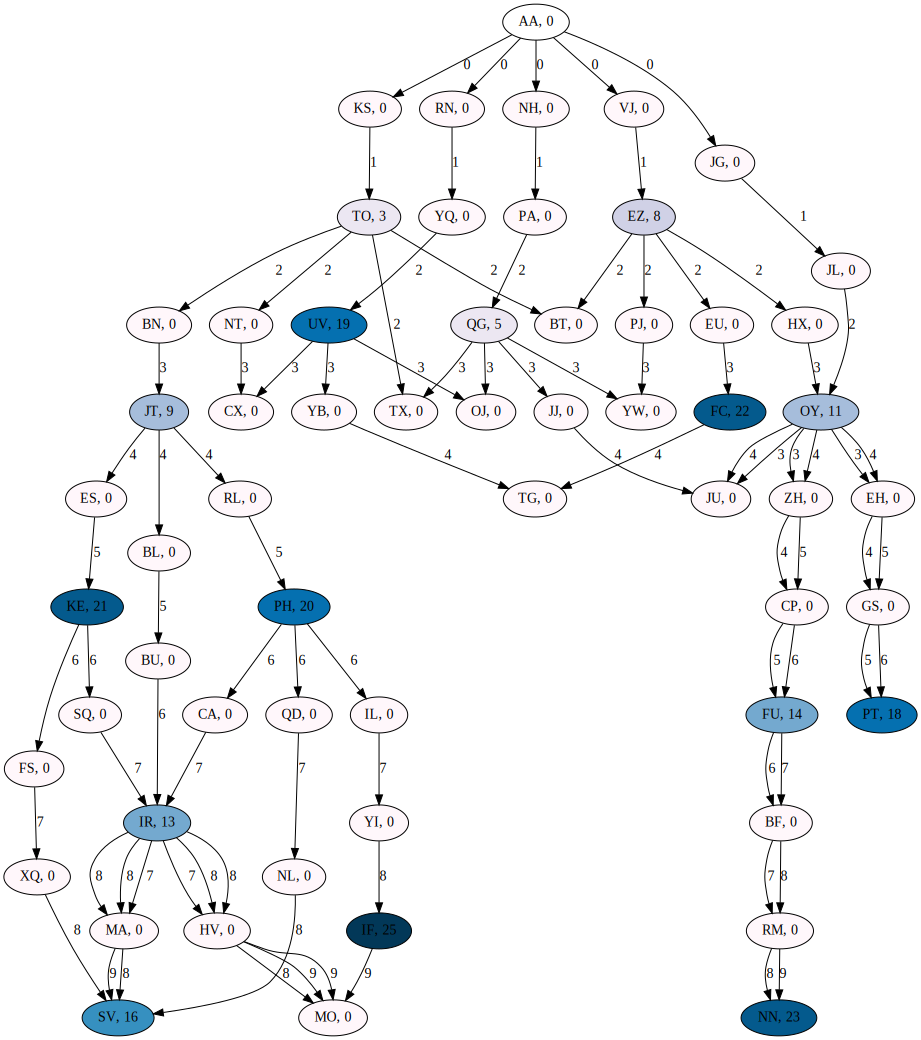

In [5]:
g

In [6]:
class Path():
    
    nodes = []
    pressure_release = []
    open_valves = []
    next_release = 0
    
    def __init__(self, initial_nodes):
        
        self.nodes = initial_nodes
        self.find_open_valves()
        

    def __repr__(self):
        wstr = "Nodes: {}\tPressure Release: {}\tOpen Valves: {}\tNext release: {}".format(self.nodes,self.pressure_release,self.open_valves,self.next_release)
        return wstr

    def find_open_valves(self):
        '''Fill the open_valves list using the nodes list.  While doing so also fills in pressure release'''
        
        #Reset the values
        self.open_valves = []        
        self.pressure_release = [0]
        self.next_release = 0
        
        for i in range(len(self.nodes) - 1):
            self.pressure_release.append(self.next_release)
            if self.nodes[i] == self.nodes[i+1]:                 
                if self.nodes[i] not in self.open_valves:
                    self.open_valves.append(self.nodes[i])
                    self.next_release = self.next_release + flow_rates[self.nodes[i]]
                
    
    def add_node(self,node):
        """
        Add a node to the path.  In the process update the pressure_release and open_valves lists
        """
        assert(len(self.nodes) > 0)
        self.nodes.append(node)
        self.pressure_release.append(self.next_release)
        if self.nodes[-1] == self.nodes[-2]:
            if node not in self.open_valves:
                self.open_valves.append(node)
                self.next_release = self.next_release + flow_rates[node]
    
    def total_release(self):
        return sum(self.pressure_release)
    

    def upper_bound_on_max_score(self,total_minutes):
        
        time_remaining = total_minutes - len(self.nodes) +1
        assert(time_remaining >= 0)
        
        guaranteed = self.guaranteed_score(total_minutes)
        
        #Bound the future potential---this could be sharpened
        unopened_rates = [flow_rates[x] for x in flow_rates if x not in self.open_valves]
        #bound_on_potential_release = time_remaining * sum(unopened_rates) 
        unopened_rates.sort(reverse = True)
        bound_on_potential_release = 0
        for ur in unopened_rates:
            bound_on_potential_release = bound_on_potential_release + ur*time_remaining
            time_remaining = max(time_remaining - 2,0)
        
        return bound_on_potential_release + guaranteed
    
    def guaranteed_score(self, total_minutes):
        time_remaining = total_minutes - len(self.nodes) +1
        assert(time_remaining >= 0)
        known_future_release = time_remaining*self.next_release
        already_released = self.total_release()
        return known_future_release + already_released
    
    def validate_path(self):
        """
        Checks to make sure each connection is an allowed tunnel
        """
        for i in range(len(self.nodes) -1 ):
            if (self.nodes[i] != self.nodes[i+1]) and (self.nodes[i+1] not in tunnels[self.nodes[i]]):
                return False            
        return True
    
        
        
                   

In [8]:
test_route = ['AA','VJ','EZ','EZ','EU','FC','FC']
test_route = ['AA', 'RN', 'YQ', 'UV', 'UV', 'YB', 'TG', 'FC', 'FC', 'EU', 'EZ', 'EZ', 'BT', 'TO', 'BN', 'JT', 'JT', 'ES', 'KE', 'KE', 'SQ', 'IR', 'IR', 'CA', 'PH', 'PH', 'IL', 'YI', 'IF', 'IF', 'MO']
#test_route = ['AA', 'DD','DD','CC','BB','BB','AA','II','JJ','JJ','II','AA','DD','EE','FF','GG','HH','HH','GG','FF','EE','EE','DD','CC','CC','CC','CC','CC','CC','CC','CC']

tp = Path(['AA'])
for n in test_route[1:]:
    tp.add_node(n)
    #print(tp)
    print(tp.total_release(),tp.guaranteed_score(30),tp.upper_bound_on_max_score(30))
    #print()

0 0 4251
0 0 4024
0 0 3800
0 494 3954
19 494 3749
38 494 3544
57 494 3344
76 978 3492
117 978 3314
158 978 3136
199 1130 3118
248 1130 2948
297 1130 2787
346 1130 2626
395 1130 2476
444 1256 2452
502 1256 2315
560 1256 2178
618 1487 2261
697 1487 2145
776 1487 2043
855 1591 2045
947 1591 1959
1039 1591 1873
1131 1691 1903
1243 1691 1837
1355 1691 1789
1467 1691 1741
1579 1716 1739
1716 1716 1716


In [9]:

def extend_nodelists(node_lists):
    """
    Input:
        node_lists    A list of paths.  
    
    Output:
        new_node_lists    A lists of paths where each path is extended by one node
                  that is an allowed next node.

    Assumptions:  There are global dictionaries 
        flow_rates      contains the flow rate for each entry in the list nodes
        tunnels         for each node, lists the valid tunnels from that node


    """
    new_node_lists = []
    for l in node_lists:
        last_node = l.nodes[-1]
        if flow_rates[last_node] > 0:
            if last_node not in l.open_valves:
                npath = Path(l.nodes + [last_node])
                new_node_lists.append(npath)  #Stay on the same node & open
        
        for n in tunnels[last_node]:
            new_node_lists.append(Path(l.nodes + [n]))   #Go through the tunnels
    return new_node_lists

         




In [10]:
n1 = extend_nodelists([Path(['AA'])])

In [11]:
n1

[Nodes: ['AA', 'RN']	Pressure Release: [0, 0]	Open Valves: []	Next release: 0,
 Nodes: ['AA', 'NH']	Pressure Release: [0, 0]	Open Valves: []	Next release: 0,
 Nodes: ['AA', 'VJ']	Pressure Release: [0, 0]	Open Valves: []	Next release: 0,
 Nodes: ['AA', 'JG']	Pressure Release: [0, 0]	Open Valves: []	Next release: 0,
 Nodes: ['AA', 'KS']	Pressure Release: [0, 0]	Open Valves: []	Next release: 0]

In [12]:

SIZE_BOUND = 4000

n = {}
n[0] = [Path(['AA'])]
for i in range(1,31):
    n[i] = extend_nodelists(n[i-1])
    if len(n[i]) > SIZE_BOUND:
        n[i].sort(key = lambda x: x.upper_bound_on_max_score(30), reverse=True)
        n[i] = n[i][:SIZE_BOUND]
    #if i%6 == 0:
    #    ov = int(i/6)
    #    print("Pruning at ", ov, len(n[i]))
    #    n[i] = [p for p in n[i] if len(p.open_valves) >= ov]
    #    print("down to  ", len(n[i]))
        
    #for p in n[i]:
    #    print(p, p.upper_bound_on_max_score(30))
    #print()
    print(i, '\t',len(n[i]))
    

1 	 5
2 	 10
3 	 43
4 	 103
5 	 404
6 	 1078
7 	 3915
8 	 4000
9 	 4000
10 	 4000
11 	 4000
12 	 4000
13 	 4000
14 	 4000
15 	 4000
16 	 4000
17 	 4000
18 	 4000
19 	 4000
20 	 4000
21 	 4000
22 	 4000
23 	 4000
24 	 4000
25 	 4000
26 	 4000
27 	 4000
28 	 4000
29 	 4000
30 	 4000


In [13]:
#n[6].sort(key = lambda x: x.upper_bound_on_max_score(30))
#for p in n[6]:
#    print(p.nodes, '\t',p.guaranteed_score(30),'\t', p.upper_bound_on_max_score(30), p.open_valves)
    

In [14]:
np.unique([p.upper_bound_on_max_score(30) for p in n[30]])

array([1643, 1644, 1645, 1646, 1650, 1651, 1653, 1654, 1655, 1657, 1658, 1659, 1660, 1661, 1663, 1664, 1665, 1666, 1667, 1669, 1670, 1671, 1672, 1674, 1675, 1676, 1679, 1680, 1681, 1684, 1685, 1690, 1691, 1695, 1701, 1707, 1710, 1716])

In [15]:
np.unique([p.total_release() for p in n[30]])

array([1643, 1644, 1645, 1646, 1650, 1651, 1653, 1654, 1655, 1657, 1658, 1659, 1660, 1661, 1663, 1664, 1665, 1666, 1667, 1669, 1670, 1671, 1672, 1674, 1675, 1676, 1679, 1680, 1681, 1684, 1685, 1690, 1691, 1695, 1701, 1707, 1710, 1716])

In [16]:
np.unique([p.guaranteed_score(30) for p in n[30]])

array([1643, 1644, 1645, 1646, 1650, 1651, 1653, 1654, 1655, 1657, 1658, 1659, 1660, 1661, 1663, 1664, 1665, 1666, 1667, 1669, 1670, 1671, 1672, 1674, 1675, 1676, 1679, 1680, 1681, 1684, 1685, 1690, 1691, 1695, 1701, 1707, 1710, 1716])

In [17]:
[p for p in n[30] if p.total_release()==1716]

[Nodes: ['AA', 'RN', 'YQ', 'UV', 'UV', 'YB', 'TG', 'FC', 'FC', 'EU', 'EZ', 'EZ', 'BT', 'TO', 'BN', 'JT', 'JT', 'ES', 'KE', 'KE', 'SQ', 'IR', 'IR', 'CA', 'PH', 'PH', 'IL', 'YI', 'IF', 'IF', 'MO']	Pressure Release: [0, 0, 0, 0, 0, 19, 19, 19, 19, 41, 41, 41, 49, 49, 49, 49, 49, 58, 58, 58, 79, 79, 79, 92, 92, 92, 112, 112, 112, 112, 137]	Open Valves: ['UV', 'FC', 'EZ', 'JT', 'KE', 'IR', 'PH', 'IF']	Next release: 137,
 Nodes: ['AA', 'RN', 'YQ', 'UV', 'UV', 'YB', 'TG', 'FC', 'FC', 'EU', 'EZ', 'EZ', 'BT', 'TO', 'BN', 'JT', 'JT', 'ES', 'KE', 'KE', 'SQ', 'IR', 'IR', 'CA', 'PH', 'PH', 'IL', 'YI', 'IF', 'IF', 'YI']	Pressure Release: [0, 0, 0, 0, 0, 19, 19, 19, 19, 41, 41, 41, 49, 49, 49, 49, 49, 58, 58, 58, 79, 79, 79, 92, 92, 92, 112, 112, 112, 112, 137]	Open Valves: ['UV', 'FC', 'EZ', 'JT', 'KE', 'IR', 'PH', 'IF']	Next release: 137]

## Elephant versions

Because if you don't just cut and paste, you can't make truly massive messes

In [18]:
class Elephant():
    
    nodes = []
    enodes = []
    pressure_release = []
    epressure_release = []
    open_valves = []
    next_release = 0
    enext_release = 0
    
    def __init__(self, initial_nodes,enodes):
        
        self.nodes = initial_nodes
        self.enodes = enodes  #elephant
        assert(len(self.nodes) == len(self.enodes))
        self.find_open_valves()
        

    def __repr__(self):
        wstr = "Nodes: {}\tPressure Release: {}\tOpen Valves: {}\tNext release: {}\n".format(self.nodes,self.pressure_release,self.open_valves,self.next_release)
        wstr = wstr + "Nodes: {}\tPressure Release: {}\tOpen Valves: {}\tNext release: {} It's an ELEPHANT".format(self.enodes,self.epressure_release,self.open_valves,self.enext_release)
        
        return wstr

    def find_open_valves(self):
        '''Fill the open_valves list using the nodes list.  While doing so also fills in pressure release'''
        
        #Reset the values
        self.open_valves = []        
        self.pressure_release = [0]
        self.next_release = 0
        self.epressure_release = [0]  #elephant
        self.enext_release = 0  #elephant
        
        
        for i in range(len(self.nodes) - 1):
            self.pressure_release.append(self.next_release)
            self.epressure_release.append(self.enext_release)   #elephant
            
            if self.nodes[i] == self.nodes[i+1]:                 
                if self.nodes[i] not in self.open_valves:
                    self.open_valves.append(self.nodes[i])
                    self.next_release = self.next_release + flow_rates[self.nodes[i]]
 
            if self.enodes[i] == self.enodes[i+1]:                 #elephant  
                if self.enodes[i] not in self.open_valves:           #elephant
                    self.open_valves.append(self.enodes[i])  #elephant
                    self.enext_release = self.enext_release + flow_rates[self.enodes[i]]    #elephant
    
    def total_release(self):
        return sum(self.pressure_release + self.epressure_release) #elephant

    
    def guaranteed_score(self, total_minutes):
        time_remaining = total_minutes - len(self.nodes) +1
        assert(time_remaining >= 0)
        known_future_release = time_remaining*(self.next_release + self.enext_release) #elephant
        already_released = self.total_release()
        return known_future_release + already_released
    
    

    def upper_bound_on_max_score(self,total_minutes):
        
        time_remaining = total_minutes - len(self.nodes) +1
        assert(time_remaining >= 0)
        
        guaranteed = self.guaranteed_score(total_minutes)
        
        #Bound the future potential---this could be sharpened
        unopened_rates = [flow_rates[x] for x in flow_rates if x not in self.open_valves]
        #bound_on_potential_release = time_remaining * sum(unopened_rates) 
        unopened_rates.sort(reverse = True)
        bound_on_potential_release = 0
        
        idx = 0
        while idx < len(unopened_rates):
            ur = unopened_rates[idx]
            bound_on_potential_release = bound_on_potential_release + ur*time_remaining
            idx = idx + 1
            if idx < len(unopened_rates):   #elephant is now opening next good node
                ur = unopened_rates[idx]
                bound_on_potential_release = bound_on_potential_release + ur*time_remaining
                idx = idx + 1
            time_remaining = max(time_remaining - 2,0)
        
        return bound_on_potential_release + guaranteed
    
    
        
        
                   

In [19]:
#tester = [['AA', 'RN', 'YQ', 'UV', 'UV', 'YB', 'TG', 'FC', 'FC', 'EU', 'EZ', 'EZ', 'BT', 'TO', 'BN', 'JT', 'JT', 'ES', 'KE', 'KE', 'SQ', 'IR', 'IR', 'CA', 'PH', 'PH', 'IL', 'YI', 'IF', 'IF', 'MO'],['AA', 'RN', 'YQ', 'UV', 'UV', 'YB', 'TG', 'FC', 'FC', 'EU', 'EZ', 'EZ', 'BT', 'TO', 'BN', 'JT', 'JT', 'ES', 'KE', 'KE', 'SQ', 'IR', 'IR', 'CA', 'PH', 'PH', 'IL', 'YI', 'IF', 'IF', 'MO']]
#test_route = ['AA', 'DD','DD','CC','BB','BB','AA','II','JJ','JJ','II','AA','DD','EE','FF','GG','HH','HH','GG','FF','EE','EE','DD','CC','CC','CC','CC','CC','CC','CC','CC']

tp = Elephant(['AA'],['AA'])
tp

Nodes: ['AA']	Pressure Release: [0]	Open Valves: []	Next release: 0
Nodes: ['AA']	Pressure Release: [0]	Open Valves: []	Next release: 0 It's an ELEPHANT

In [20]:
#tp = Elephant(test_route[:10],test_route[10:20])
#tp


In [40]:
def elephant_extend_nodelists(node_lists):
    """
    Input:
        node_lists    A list of paths.  
    
    Output:
        new_node_lists    A lists of paths where each path is extended by one node
                  that is an allowed next node.

    Assumptions:  There are global dictionaries 
        flow_rates      contains the flow rate for each entry in the list nodes
        tunnels         for each node, lists the valid tunnels from that node


    """
    new_node_lists = []
    for l in node_lists:
        
        last_node = l.nodes[-1]
        elast_node = l.enodes[-1]
        #print(last_node, elast_node)
        possible_next = [x for x in tunnels[last_node]]
        epossible_next = [x for x in tunnels[elast_node]]
        #print(possible_next)
        #print(epossible_next)

        
        
        if flow_rates[last_node]>0 and last_node not in l.open_valves:
            possible_next.append(last_node)
 
        if flow_rates[elast_node]>0 and elast_node not in l.open_valves and elast_node!=last_node:
            epossible_next.append(elast_node)
        #print(possible_next)
        #print(epossible_next)
        #print ('There are {} nodes and {} Elephant nodes for {} possibilities'.format(len(possible_next),len(epossible_next),len(possible_next)*len(epossible_next)))

        if last_node == elast_node:
            assert(len(possible_next) == len(epossible_next))
            for i in range(len(possible_next)):
                for j in range(i+1,len(possible_next)):
                    new_node_lists.append(Elephant(l.nodes + [possible_next[i]],l.enodes + [possible_next[j]])) 
        else:
            for n in possible_next:
                for en in epossible_next:
                    if en != n:
                        new_node_lists.append(Elephant(l.nodes + [n],l.enodes + [en])) 
                
        #print()           
                    
        
        """
        
        
        if flow_rates[last_node] > 0:
            if last_node not in l.open_valves:
                #Not going to bother trying to cut down for the elephants actions.  Too lazy to figure out code
                new_node_lists.append(Elephant(l.nodes + [last_node],l.enodes + [elast_node]))
                for en in tunnels[elast_node]:
                    new_node_lists.append(Elephant(l.nodes + [last_node],l.enodes + [en]))   #Go through the tunnels
                    
        for n in tunnels[last_node]:
            for en in tunnels[elast_node]:
                if en != n or n not in l.open_valves:
                    new_node_lists.append(Elephant(l.nodes + [n],l.enodes + [en]))   #Go through the tunnels
        """        
                    
    return new_node_lists



In [41]:
n1 = elephant_extend_nodelists([Elephant(['AA'],['AA'])])

In [42]:
tunnels['AA']

['RN', 'NH', 'VJ', 'JG', 'KS']

In [43]:
n2 = elephant_extend_nodelists(n1)
n2

[Nodes: ['AA', 'RN', 'AA']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0
 Nodes: ['AA', 'NH', 'PA']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0 It's an ELEPHANT,
 Nodes: ['AA', 'RN', 'YQ']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0
 Nodes: ['AA', 'NH', 'PA']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0 It's an ELEPHANT,
 Nodes: ['AA', 'RN', 'YQ']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0
 Nodes: ['AA', 'NH', 'AA']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0 It's an ELEPHANT,
 Nodes: ['AA', 'RN', 'AA']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0
 Nodes: ['AA', 'VJ', 'EZ']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0 It's an ELEPHANT,
 Nodes: ['AA', 'RN', 'YQ']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0
 Nodes: ['AA', 'VJ', 'EZ']	Pressure Release: [0, 0, 0]	Open Valves: []	Next release: 0 It's an ELEPHANT,
 Nodes: ['AA', 'RN', 'YQ']	Pressure Rele

In [44]:
SIZE_BOUND = 24000

et = {}
et[0] = [Elephant(['AA'],['AA'])]
for i in range(1,27):
    et[i] = elephant_extend_nodelists(et[i-1])
    if len(et[i]) > SIZE_BOUND:
        et[i].sort(key = lambda x: x.upper_bound_on_max_score(26), reverse=True)
        et[i] = et[i][:SIZE_BOUND]
    #if i%6 == 0:
    #    ov = int(i/6)
    #    print("Pruning at ", ov, len(n[i]))
    #    n[i] = [p for p in n[i] if len(p.open_valves) >= ov]
    #    print("down to  ", len(n[i]))
        
    #for p in n[i]:
    #    print(p, p.upper_bound_on_max_score(30))
    #print()
    print(i, '\t',len(et[i]))
    

1 	 10
2 	 30
3 	 459
4 	 2969
5 	 24000
6 	 24000
7 	 24000
8 	 24000
9 	 24000
10 	 24000
11 	 24000
12 	 24000
13 	 24000
14 	 24000
15 	 24000
16 	 24000
17 	 24000
18 	 24000
19 	 24000
20 	 24000
21 	 24000
22 	 24000
23 	 24000
24 	 24000
25 	 24000
26 	 24000


In [45]:
np.unique([p.total_release() for p in et[26]])

array([2446, 2447, 2448, 2449, 2450, 2452, 2453, 2458, 2459, 2460, 2462, 2463, 2464, 2469, 2472, 2474, 2478, 2479, 2484, 2488, 2494, 2495, 2504])

In [46]:
np.unique([p.total_release() for p in et[26]])

array([2446, 2447, 2448, 2449, 2450, 2452, 2453, 2458, 2459, 2460, 2462, 2463, 2464, 2469, 2472, 2474, 2478, 2479, 2484, 2488, 2494, 2495, 2504])

In [50]:
h = [p for p in et[26] if p.total_release()==2504]

In [51]:
len(h)

36

In [52]:
h[0]

Nodes: ['AA', 'RN', 'YQ', 'UV', 'UV', 'YB', 'TG', 'FC', 'FC', 'EU', 'EZ', 'EZ', 'HX', 'OY', 'OY', 'ZH', 'CP', 'FU', 'FU', 'BF', 'RM', 'NN', 'NN', 'RM', 'NN', 'RM', 'NN']	Pressure Release: [0, 0, 0, 0, 0, 19, 19, 19, 19, 41, 41, 41, 49, 49, 49, 60, 60, 60, 60, 74, 74, 74, 74, 97, 97, 97, 97]	Open Valves: ['UV', 'JT', 'FC', 'KE', 'EZ', 'IR', 'OY', 'PH', 'FU', 'IF', 'NN', 'SV']	Next release: 97
Nodes: ['AA', 'KS', 'TO', 'BN', 'JT', 'JT', 'ES', 'KE', 'KE', 'SQ', 'IR', 'IR', 'CA', 'PH', 'PH', 'IL', 'YI', 'IF', 'IF', 'MO', 'HV', 'IR', 'MA', 'SV', 'SV', 'NL', 'SV']	Pressure Release: [0, 0, 0, 0, 0, 0, 9, 9, 9, 30, 30, 30, 43, 43, 43, 63, 63, 63, 63, 88, 88, 88, 88, 88, 88, 104, 104]	Open Valves: ['UV', 'JT', 'FC', 'KE', 'EZ', 'IR', 'OY', 'PH', 'FU', 'IF', 'NN', 'SV']	Next release: 104 It's an ELEPHANT

In [32]:
type(h)

__main__.Elephant

In [49]:
h = [p for p in et[26] if p.total_release()==2469][0]